# Gradient Boosting Models Exercise: Advanced Ensemble Methods

**ML2 Course - Extra Points Assignment (5 points)**

**Objective:**
The goal of this exercise is to explore and master various gradient boosting algorithms for panel data modeling. You will implement and compare seven state-of-the-art boosting models that represent the cutting edge of machine learning regression techniques.

**Models to Implement:**

1. **AdaBoost** ([AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)) - Adaptive Boosting, the pioneering boosting algorithm
2. **GBM** ([GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)) - Classic Gradient Boosting Machine from scikit-learn
3. **GBM Histogram** ([HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)) - Histogram-based Gradient Boosting (faster, inspired by LightGBM)
4. **XGBoost** ([XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor)) - Extreme Gradient Boosting, industry standard
5. **LightGBM** ([LGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)) - Light Gradient Boosting Machine, optimized for speed and memory
6. **CatBoost** ([CatBoostRegressor](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor)) - Categorical Boosting, handles categorical features natively
7. **XGBoostLSS** ([XGBoostLSS](https://github.com/StatMixedML/XGBoostLSS)) - XGBoost for Location, Scale and Shape, probabilistic predictions

**Tasks Workflow:**

Following a similar process to the SVM / KNN model (`notebooks/07.knn-model.ipynb`):

1. **Load the prepared training data** from the preprocessing step
2. **Feature Engineering** (if necessary): `-> done in previous analyses, let's start with step 3`
   - Note: Tree-based models do NOT require standardization/normalization
   - They are invariant to monotonic transformations of features
3. **Feature Selection**:
   - Use existing feature rankings from `feature_ranking.xlsx` for initial feature selection
   - Consider feature importance from tree-based models
   - Test multiple feature sets (top 20, 30, 50 features, etc.) - please utilize Feature Importance directly from models
4. **Hyperparameter Tuning**: (2 points)
   - Use GridSearchCV or RandomizedSearchCV, or Optuna
   - Focus on key parameters: learning rate, boosting iterations, tree max depth, regularization (if applicable) etc. 
   - Use rolling window cross-validation to avoid data leakage
5. **Identify Local Champions**: (1 point)
   - Select the best model for each algorithm class
   - Compare based on RMSE on validation sets
6. **Save Models**:
   - Pickle the best models for each algorithm
   - Save to `../models/` directory

**Important Notes:**

- Gradient boosting models are powerful but prone to overfitting - pay attention to regularization
- Learning rate and number of estimators have an inverse relationship
- Early stopping can be used to prevent overfitting
- XGBoostLSS provides distributional forecasts (not just point estimates)
- Use time-series aware cross-validation (rolling window) for final model selection

**Model Evaluation:** (2 points)

After completing this notebook:
- Load your models in `notebooks/09.final-comparison-and-summary.ipynb`
- Compare them against existing models (OLS, ARMA, ARDL, KNN, SVR)
- Check if any gradient boosting model becomes the new champion!

---

## Submission Requirements

- Complete this notebook with code and outputs
- Save best model(s) as pickle files in `models/` directory
- Commit and push to your GitHub repository
- Send repository link to: **mj.wozniak9@uw.edu.pl**

**Deadline:** `21-23rd of November, so two weeks from now`

# Dependencies loading

In [130]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# AdaBoost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
#from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

# GBM
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error

# GBM Histogram
from sklearn.ensemble import HistGradientBoostingRegressor

# XGBoost
import xgboost as xgb

# LightGBM
import lightgbm as lgb

# CatBoost
from catboost import CatBoostRegressor

# XGBoostLSS
from xgboostlss.model import *

# Data loading

As suggested by the lecturer, **we will start with point 3** in the Tasks Workflow as the preeliminary feature engineering was done in the previous course (refer to earlier notebooks for the exact processes). So, we begin with `feature_ranking.xlsx` as a guide for feature ranking, `train_fe.csv` as our training dataset, and `test_fe.csv` as our testing dataset.

In [99]:
preprocessed_output_data_path = "../data/output"

# These data will be used for CV and choosing the best models
df_train = pd.read_csv(f"{preprocessed_output_data_path}/train_fe.csv", index_col=0)

# We will use this set to test the forecasting power of our best models (final comparisons)
df_valid = pd.read_csv(f"{preprocessed_output_data_path}/test_fe.csv", index_col=0)

fr = pd.read_excel(f"{preprocessed_output_data_path}/feature_ranking.xlsx", index_col=0)

In [100]:
print(df_train.columns.tolist())

['Ticker', 'Nazwa2', 'rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'etr', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4', 'gielda_5', 'ta_log', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(25.05, 308.55]', 'txt_cat_(308.55, 327.531]', 'txt_cat_(327.531, inf]', 'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_c

In [101]:
print(df_valid.columns.tolist())

['Ticker', 'Nazwa2', 'rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'etr', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4', 'gielda_5', 'ta_log', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(25.05, 308.55]', 'txt_cat_(308.55, 327.531]', 'txt_cat_(327.531, inf]', 'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_c

In [102]:
print(fr.columns.tolist())

['mi_score', 'sign_fscore', 'sign_fscore_0_1', 'corr', 'EN_coef', 'boruta_rank']


In [103]:
# Assigning our x variables (features) and y variable (etr - label)

# Features = all columns except "etr"
train_x = df_train.drop(columns=["etr"])
test_x  = df_valid.drop(columns=["etr"])

# Labels = the "etr" column
train_y = df_train["etr"]
valid_y  = df_valid["etr"]

In [104]:
print(train_x.columns.tolist())

print(test_x.columns.tolist())

print(train_y)

print(valid_y)

['Ticker', 'Nazwa2', 'rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4', 'gielda_5', 'ta_log', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(25.05, 308.55]', 'txt_cat_(308.55, 327.531]', 'txt_cat_(327.531, inf]', 'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_cat_(810

## Initial feature selection

Let's take the features which have the best Boruta rank

In [105]:
fr = fr.sort_values(by="boruta_rank")
fr

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
txt,0.633067,5.246456e-13,1,0.368732,0.000015,1
diff,0.632640,2.257712e-02,1,-0.291716,NaN,1
WB_GDPpc,0.138161,2.661700e-49,1,0.287213,0.000002,1
etr_y_ma,0.825650,2.473770e-125,1,0.526871,NaN,1
diff_ma,0.571142,2.597416e-03,1,-0.252605,NaN,1
...,...,...,...,...,...,...
"txt_cat_(327.531, inf]",0.035442,2.168974e-18,1,0.212768,NaN,104
sektor_health care,0.028910,5.320343e-01,0,0.005914,NaN,104
"pi_cat_(8108.5, inf]",0.008406,1.636994e-04,1,0.086622,NaN,104
y_BR_Democracy,0.000000,1.000000e+00,0,NaN,NaN,106


Let's create different sets of variables by choosing the best 10, 20, 30, 40, and 50 features based on Boruta rank

In [106]:
br10_feat = fr.iloc[0:10].index.tolist()
print(br10_feat)

['txt', 'diff', 'WB_GDPpc', 'etr_y_ma', 'diff_ma', 'etr_y_past', 'dlc_cat_(176.129, 200.9]', 'pi', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(308.55, 327.531]']


In [107]:
br20_feat = fr.iloc[0:20].index.tolist()
print(br20_feat)

['txt', 'diff', 'WB_GDPpc', 'etr_y_ma', 'diff_ma', 'etr_y_past', 'dlc_cat_(176.129, 200.9]', 'pi', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(308.55, 327.531]', 'pi_cat_(7875.5, 8108.5]', 'roa_past', 'ni', 'str', 'lev_past', 'txt_cat_(24.415, 25.05]', 'sale', 'xrd', 'diff_dta', 'lev_ma']


In [108]:
br30_feat = fr.iloc[0:30].index.tolist()
print(br30_feat)

['txt', 'diff', 'WB_GDPpc', 'etr_y_ma', 'diff_ma', 'etr_y_past', 'dlc_cat_(176.129, 200.9]', 'pi', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(308.55, 327.531]', 'pi_cat_(7875.5, 8108.5]', 'roa_past', 'ni', 'str', 'lev_past', 'txt_cat_(24.415, 25.05]', 'sale', 'xrd', 'diff_dta', 'lev_ma', 'revenue', 'cfc', 'roa_clip', 'dlc', 'rok', 'rr_per_sector', 'roa', 'capex_cat_(5451.0, inf]', 'WB_GDPgrowth', 'ppent']


In [109]:
br40_feat = fr.iloc[0:40].index.tolist()
print(br40_feat)

['txt', 'diff', 'WB_GDPpc', 'etr_y_ma', 'diff_ma', 'etr_y_past', 'dlc_cat_(176.129, 200.9]', 'pi', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(308.55, 327.531]', 'pi_cat_(7875.5, 8108.5]', 'roa_past', 'ni', 'str', 'lev_past', 'txt_cat_(24.415, 25.05]', 'sale', 'xrd', 'diff_dta', 'lev_ma', 'revenue', 'cfc', 'roa_clip', 'dlc', 'rok', 'rr_per_sector', 'roa', 'capex_cat_(5451.0, inf]', 'WB_GDPgrowth', 'ppent', 'cce', 'ppent_sqrt', 'roa_ma', 'capex', 'capex2', 'ppe_clip', 'ppe_ma', 'WB_Inflation', 'ppe', 'sale_ma']


In [110]:
br50_feat = fr.iloc[0:50].index.tolist()
print(br50_feat)

['txt', 'diff', 'WB_GDPpc', 'etr_y_ma', 'diff_ma', 'etr_y_past', 'dlc_cat_(176.129, 200.9]', 'pi', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(308.55, 327.531]', 'pi_cat_(7875.5, 8108.5]', 'roa_past', 'ni', 'str', 'lev_past', 'txt_cat_(24.415, 25.05]', 'sale', 'xrd', 'diff_dta', 'lev_ma', 'revenue', 'cfc', 'roa_clip', 'dlc', 'rok', 'rr_per_sector', 'roa', 'capex_cat_(5451.0, inf]', 'WB_GDPgrowth', 'ppent', 'cce', 'ppent_sqrt', 'roa_ma', 'capex', 'capex2', 'ppe_clip', 'ppe_ma', 'WB_Inflation', 'ppe', 'sale_ma', 'lev', 'intant_sqrt', 'capex2_scaled', 'lev_sqrt', 'ppe_past', 'intant', 'cash_holdings_ma', 'sale_past', 'rd', 'str_cat_(0.28, inf]']


Now, we create datasets which only have the best features (10,20,30,40 and 50 accordingly)

In [111]:
feat10 = [c for c in br10_feat if c in df_train.columns and c != "etr"]
train_br10 = df_train[feat10 + ["etr"]].copy()

feat20 = [c for c in br20_feat if c in df_train.columns and c != "etr"]
train_br20 = df_train[feat20 + ["etr"]].copy()

feat30 = [c for c in br30_feat if c in df_train.columns and c != "etr"]
train_br30 = df_train[feat30 + ["etr"]].copy()

feat40 = [c for c in br40_feat if c in df_train.columns and c != "etr"]
train_br40 = df_train[feat40 + ["etr"]].copy()

feat50 = [c for c in br50_feat if c in df_train.columns and c != "etr"]
train_br50 = df_train[feat50 + ["etr"]].copy()

In [112]:
# Output check
train_br10

,txt,diff,WB_GDPpc,etr_y_ma,diff_ma,etr_y_past,"dlc_cat_(176.129, 200.9]",pi,"txt_cat_(-63.011, -34.811]","txt_cat_(308.55, 327.531]",etr
0,1.24185,-0.006193,8021.003655,0.196193,-0.006193,0.196193,0,6.329725,0,0,0.196193
1,1.24185,-0.006193,9038.730847,0.196193,-0.006193,0.196193,0,6.329725,0,0,0.196193
2,1.24185,-0.006193,11255.436700,0.196193,-0.006193,0.196193,0,6.329725,0,0,0.196193
3,1.24185,-0.006193,14001.446880,0.196193,-0.006193,0.196193,0,6.329725,0,0,0.196193
4,1.24185,-0.006193,11527.593230,0.196193,-0.006193,0.196193,0,6.329725,0,0,0.188487
...,...,...,...,...,...,...,...,...,...,...,...
4350,7.99200,-0.056553,13893.509260,0.300581,-0.093113,0.246553,0,32.415001,0,0,0.198160
4351,7.32400,-0.008160,13145.539260,0.222356,-0.110581,0.198160,0,36.959999,0,0,0.191713
4352,7.08800,-0.001713,13781.062610,0.194936,-0.032356,0.191713,0,36.972000,0,0,0.140018
4353,4.07900,0.049982,14347.914580,0.165865,-0.004936,0.140018,0,29.132000,0,0,0.192851


In [113]:
train_br20

,txt,diff,WB_GDPpc,etr_y_ma,diff_ma,etr_y_past,"dlc_cat_(176.129, 200.9]",pi,"txt_cat_(-63.011, -34.811]","txt_cat_(308.55, 327.531]",...,roa_past,ni,str,lev_past,"txt_cat_(24.415, 25.05]",sale,xrd,diff_dta,lev_ma,etr
0,1.24185,-0.006193,8021.003655,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,0.240818,5.087900,0.19,0.000000,0,0.445954,0.0,-0.0,0.000000,0.196193
1,1.24185,-0.006193,9038.730847,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,0.240818,5.087900,0.19,0.000000,0,0.445954,0.0,-0.0,0.000000,0.196193
2,1.24185,-0.006193,11255.436700,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,0.240818,5.087900,0.19,0.000000,0,0.445954,0.0,-0.0,0.000000,0.196193
3,1.24185,-0.006193,14001.446880,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,0.240818,5.087900,0.19,0.000000,0,0.445954,0.0,-0.0,0.000000,0.196193
4,1.24185,-0.006193,11527.593230,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,0.240818,5.087900,0.19,0.000000,0,0.445954,0.0,-0.0,0.000000,0.188487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4350,7.99200,-0.056553,13893.509260,0.300581,-0.093113,0.246553,0,32.415001,0,0,...,0.009109,24.423000,0.19,0.177858,0,0.589539,0.0,-0.0,0.180477,0.198160
4351,7.32400,-0.008160,13145.539260,0.222356,-0.110581,0.198160,0,36.959999,0,0,...,0.119786,29.636000,0.19,0.132538,0,0.673297,0.0,-0.0,0.155198,0.191713
4352,7.08800,-0.001713,13781.062610,0.194936,-0.032356,0.191713,0,36.972000,0,0,...,0.167887,29.884001,0.19,0.081224,0,0.616978,0.0,-0.0,0.106881,0.140018
4353,4.07900,0.049982,14347.914580,0.165865,-0.004936,0.140018,0,29.132000,0,0,...,0.136526,25.052999,0.19,0.175235,0,0.599780,0.0,0.0,0.128230,0.192851


In [114]:
train_br30

,txt,diff,WB_GDPpc,etr_y_ma,diff_ma,etr_y_past,"dlc_cat_(176.129, 200.9]",pi,"txt_cat_(-63.011, -34.811]","txt_cat_(308.55, 327.531]",...,cfc,roa_clip,dlc,rok,rr_per_sector,roa,"capex_cat_(5451.0, inf]",WB_GDPgrowth,ppent,etr
0,1.24185,-0.006193,8021.003655,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,0,0.240818,0.000,2005,0.030010,0.240818,0,3.493668,0.276275,0.196193
1,1.24185,-0.006193,9038.730847,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,0,0.240818,0.000,2006,0.136194,0.240818,0,6.179641,0.276275,0.196193
2,1.24185,-0.006193,11255.436700,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,0,0.240818,0.000,2007,0.035493,0.240818,0,7.034828,0.276275,0.196193
3,1.24185,-0.006193,14001.446880,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,0,0.240818,0.000,2008,-0.384695,0.240818,0,4.249609,0.276275,0.196193
4,1.24185,-0.006193,11527.593230,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,0,0.240818,0.000,2009,0.234897,0.240818,0,2.820260,0.276275,0.188487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4350,7.99200,-0.056553,13893.509260,0.300581,-0.093113,0.246553,0,32.415001,0,0,...,0,0.119786,4.079,2011,0.027745,0.119786,0,5.017235,75.615997,0.198160
4351,7.32400,-0.008160,13145.539260,0.222356,-0.110581,0.198160,0,36.959999,0,0,...,0,0.167887,0.110,2012,0.023329,0.167887,0,1.607907,71.445000,0.191713
4352,7.08800,-0.001713,13781.062610,0.194936,-0.032356,0.191713,0,36.972000,0,0,...,0,0.136526,0.110,2013,0.221706,0.136526,0,1.391892,71.052002,0.140018
4353,4.07900,0.049982,14347.914580,0.165865,-0.004936,0.140018,0,29.132000,0,0,...,0,0.094782,11.943,2014,-0.099258,0.094782,0,3.318448,115.347000,0.192851


In [115]:
train_br40

,txt,diff,WB_GDPpc,etr_y_ma,diff_ma,etr_y_past,"dlc_cat_(176.129, 200.9]",pi,"txt_cat_(-63.011, -34.811]","txt_cat_(308.55, 327.531]",...,ppent_sqrt,roa_ma,capex,capex2,ppe_clip,ppe_ma,WB_Inflation,ppe,sale_ma,etr
0,1.24185,-0.006193,8021.003655,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,0.525619,0.240818,2.223413,8.047824,0.013076,0.013076,2.183799,0.013076,0.445954,0.196193
1,1.24185,-0.006193,9038.730847,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,0.525619,0.240818,2.223413,8.047824,0.013076,0.013076,1.284694,0.013076,0.445954,0.196193
2,1.24185,-0.006193,11255.436700,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,0.525619,0.240818,2.223413,8.047824,0.013076,0.013076,2.458743,0.013076,0.445954,0.196193
3,1.24185,-0.006193,14001.446880,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,0.525619,0.240818,2.223413,8.047824,0.013076,0.013076,4.164972,0.013076,0.445954,0.196193
4,1.24185,-0.006193,11527.593230,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,0.525619,0.240818,2.223413,8.047824,0.013076,0.013076,3.795392,0.013076,0.445954,0.188487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4350,7.99200,-0.056553,13893.509260,0.300581,-0.093113,0.246553,0,32.415001,0,0,...,8.695746,0.065114,1.602000,0.021186,0.370868,0.408827,4.239401,0.370868,0.478225,0.198160
4351,7.32400,-0.008160,13145.539260,0.222356,-0.110581,0.198160,0,36.959999,0,0,...,8.452514,0.064447,1.792000,0.025082,0.404732,0.385654,3.560372,0.404732,0.463679,0.191713
4352,7.08800,-0.001713,13781.062610,0.194936,-0.032356,0.191713,0,36.972000,0,0,...,8.429235,0.143836,6.310000,0.088808,0.324603,0.387800,0.991983,0.324603,0.631418,0.140018
4353,4.07900,0.049982,14347.914580,0.165865,-0.004936,0.140018,0,29.132000,0,0,...,10.739972,0.152206,6.750000,0.058519,0.436387,0.364668,0.053821,0.436387,0.645137,0.192851


In [116]:
train_br50

,txt,diff,WB_GDPpc,etr_y_ma,diff_ma,etr_y_past,"dlc_cat_(176.129, 200.9]",pi,"txt_cat_(-63.011, -34.811]","txt_cat_(308.55, 327.531]",...,intant_sqrt,capex2_scaled,lev_sqrt,ppe_past,intant,cash_holdings_ma,sale_past,rd,"str_cat_(0.28, inf]",etr
0,1.24185,-0.006193,8021.003655,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,2.048390,0.007469,0.000000,0.013076,4.195900,0.574744,0.445954,0.0,0,0.196193
1,1.24185,-0.006193,9038.730847,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,2.048390,0.007469,0.000000,0.013076,4.195900,0.574744,0.445954,0.0,0,0.196193
2,1.24185,-0.006193,11255.436700,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,2.048390,0.007469,0.000000,0.013076,4.195900,0.574744,0.445954,0.0,0,0.196193
3,1.24185,-0.006193,14001.446880,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,2.048390,0.007469,0.000000,0.013076,4.195900,0.574744,0.445954,0.0,0,0.196193
4,1.24185,-0.006193,11527.593230,0.196193,-0.006193,0.196193,0,6.329725,0,0,...,2.048390,0.007469,0.000000,0.013076,4.195900,0.574744,0.445954,0.0,0,0.188487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4350,7.99200,-0.056553,13893.509260,0.300581,-0.093113,0.246553,0,32.415001,0,0,...,3.981708,0.000020,0.364057,0.400440,15.854000,0.213261,0.337819,0.0,0,0.198160
4351,7.32400,-0.008160,13145.539260,0.222356,-0.110581,0.198160,0,36.959999,0,0,...,3.988483,0.000023,0.284998,0.370868,15.908000,0.144478,0.589539,0.0,0,0.191713
4352,7.08800,-0.001713,13781.062610,0.194936,-0.032356,0.191713,0,36.972000,0,0,...,4.058941,0.000082,0.418611,0.404732,16.475000,0.086577,0.673297,0.0,0,0.140018
4353,4.07900,0.049982,14347.914580,0.165865,-0.004936,0.140018,0,29.132000,0,0,...,4.139807,0.000054,0.363315,0.324603,17.138000,0.032996,0.616978,0.0,0,0.192851


In [117]:
# Labels for our train datasets
train_y

0       0.196193
1       0.196193
2       0.196193
3       0.196193
4       0.188487
          ...   
4350    0.198160
4351    0.191713
4352    0.140018
4353    0.192851
4354    0.204846
Name: etr, Length: 3993, dtype: float64

# AdaBoost

Workflow inspired by our labs about AdaBoost - this time we utilise AdaBoostRegressor

## 10 features

In [ ]:
# Step 1: Split the dataset into training and testing sets
# We need to drop etr from our "X" dataset
X_train, X_test, y_train, y_test = train_test_split(train_br10.drop(columns=["etr"]), train_y, test_size=0.2, random_state=42)

# Step 2: Create a weak regressor (e.g., Decision Tree)
base_regressor = DecisionTreeRegressor(max_depth=1)

# Step 3: Create an AdaBoost regressor
adaboost_regressor = AdaBoostRegressor(base_regressor, random_state=42)

# Step 4: Define hyperparameters for tuning
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 300, 500],  # Number of weak regressors
    'learning_rate': [0.01, 0.1, 0.5, 1.0, 5, 10] # Learning rate
}

# Step 5: Create a GridSearchCV object for hyperparameter tuning
grid_search = GridSearchCV(estimator=adaboost_regressor, param_grid=param_grid, cv=5)

# Step 6: Train the model with cross-validation
grid_search.fit(X_train, y_train)

# Step 7: Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Step 8: Get the best model
best_model = grid_search.best_estimator_

# Step 9: Make predictions on the test set using the best model
#y_pred = best_model.predict(X_test)

# Step 10: Evaluate the model - test R^2
score = best_model.score(X_test, y_test) #   grid_search.score(X_test, y_test)
print("Score (test R^2):", score )

Best Hyperparameters: {'learning_rate': 0.01, 'n_estimators': 50}
Score (test R^2): 0.08279640615210915


**From the documentation:**
The coefficient of determination, $R^2$ , is defined as $1-u/v$, where $u$ is the residual sum of squares ((y_true - y_pred)** 2).sum() and $v$ is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a score of 0.0.

We see very poor test performance

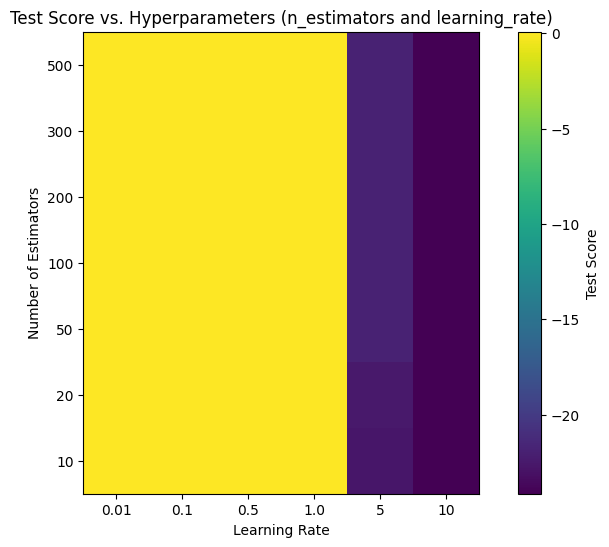

In [119]:
# Step 11: Visualize the effect of hyperparameters
n_estimators_values = [10, 20, 50, 100, 200, 300, 500]
learning_rate_values = [0.01, 0.1, 0.5, 1.0, 5, 10]
Score_grid = np.zeros((len(n_estimators_values), len(learning_rate_values)))

for i, n_estimators in enumerate(n_estimators_values):
    for j, learning_rate in enumerate(learning_rate_values):
        adaboost_regressor = AdaBoostRegressor(
            base_regressor,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=42
        )
        adaboost_regressor.fit(X_train, y_train)
        #y_pred = adaboost_regressor.predict(X_test)
        Score = adaboost_regressor.score(X_test, y_test)
        Score_grid[i, j] = Score

# Create a heatmap to visualize Score
plt.figure(figsize=(10, 6))
plt.imshow(Score_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Test Score')
plt.xlabel('Learning Rate')
plt.ylabel('Number of Estimators')
plt.title('Test Score vs. Hyperparameters (n_estimators and learning_rate)')
plt.xticks(np.arange(len(learning_rate_values)), learning_rate_values)
plt.yticks(np.arange(len(n_estimators_values)), n_estimators_values)
plt.gca().invert_yaxis()  # Invert the y-axis for better visualization
plt.show()

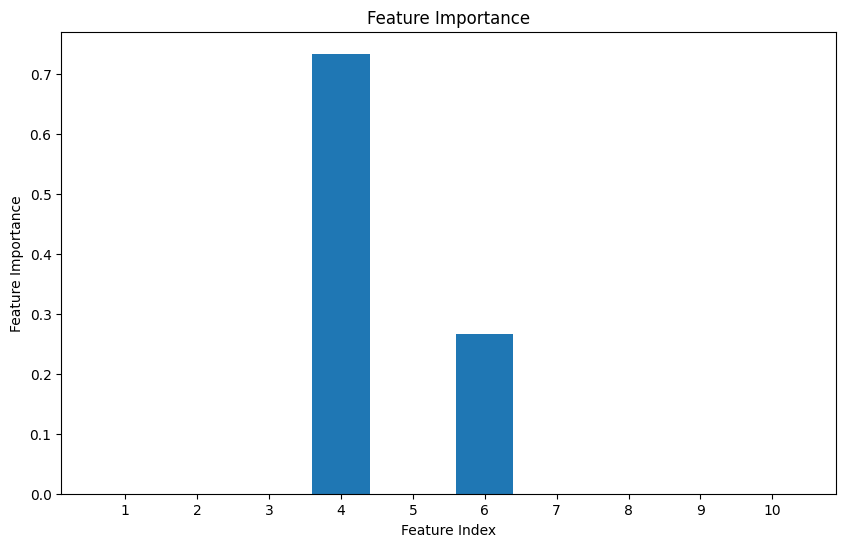

In [120]:
# Step 12: Analyze feature importance
feature_importance = best_model.feature_importances_

# Step 13: Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xticks(range(len(feature_importance)), range(1, len(feature_importance) + 1))
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

We see that only two features seem to be important in the model

Best Hyperparameters: {'learning_rate': 0.01, 'n_estimators': 50}
Score (test R^2): 0.08279640615210915


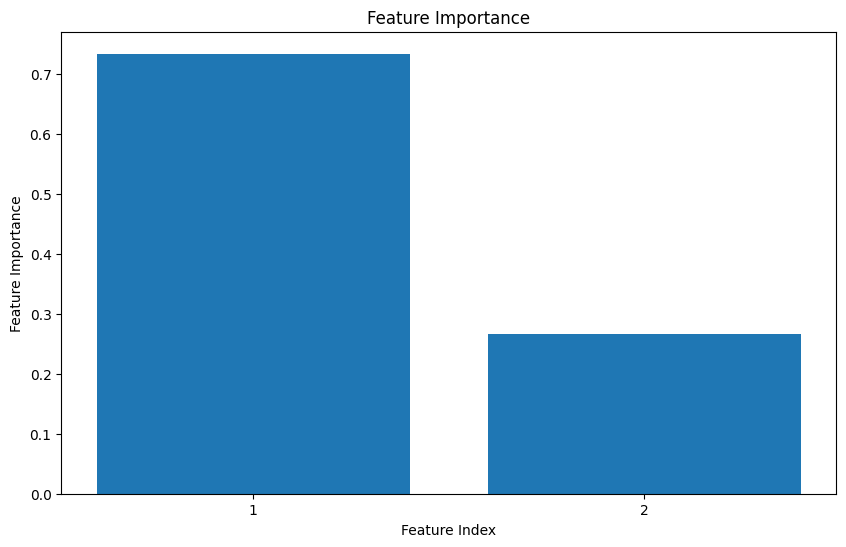

In [121]:
# Step 14: Selecting Important Features 
# Set a threshold for selecting important features (you can adjust this threshold)
threshold = 0.02

# Create a feature selector
feature_selector = SelectFromModel(best_model, threshold=threshold, prefit=True)

# Transform your dataset to select important features
X_train_selected = feature_selector.transform(X_train)
X_test_selected = feature_selector.transform(X_test)

# HP Tuning again

# Step 5: Create a GridSearchCV object for hyperparameter tuning
grid_search_selected = GridSearchCV(estimator=adaboost_regressor, param_grid=param_grid, cv=5)

# Step 6: Train the model with cross-validation
grid_search_selected.fit(X_train_selected, y_train)

# Step 7: Get the best hyperparameters
best_params = grid_search_selected.best_params_
print("Best Hyperparameters:", best_params)

# Step 8: Get the best model
best_model = grid_search_selected.best_estimator_

# Step 9: Make predictions on the test set using the best model
#y_pred = best_model.predict(X_test)

# Step 10: Evaluate the model - test R^2
score_new = grid_search_selected.score(X_test_selected, y_test)
print("Score (test R^2):", score_new )


feature_importance = grid_search_selected.best_estimator_.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xticks(range(len(feature_importance)), range(1, len(feature_importance) + 1))
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

Hardly any improvement

We seem to be underfitting, let's try a greater number of estimators

## 20 features

In [122]:
# Step 1: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_br20.drop(columns=["etr"]), train_y, test_size=0.2, random_state=42)

# Step 2: Create a weak regressor (e.g., Decision Tree)
base_regressor = DecisionTreeRegressor(max_depth=1)

# Step 3: Create an AdaBoost regressor
adaboost_regressor = AdaBoostRegressor(base_regressor, random_state=42)

# Step 4: Define hyperparameters for tuning
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 300, 500],  # Number of weak regressors
    'learning_rate': [0.01, 0.1, 0.5, 1.0, 5, 10] # Learning rate
}

# Step 5: Create a GridSearchCV object for hyperparameter tuning
grid_search = GridSearchCV(estimator=adaboost_regressor, param_grid=param_grid, cv=5)

# Step 6: Train the model with cross-validation
grid_search.fit(X_train, y_train)

# Step 7: Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Step 8: Get the best model
best_model = grid_search.best_estimator_

# Step 9: Make predictions on the test set using the best model
#y_pred = best_model.predict(X_test)

# Step 10: Evaluate the model - test R^2
score = best_model.score(X_test, y_test) #   grid_search.score(X_test, y_test)
print("Score (test R^2):", score )

Best Hyperparameters: {'learning_rate': 0.01, 'n_estimators': 50}
Score (test R^2): 0.08279640615210893


The results are very similar


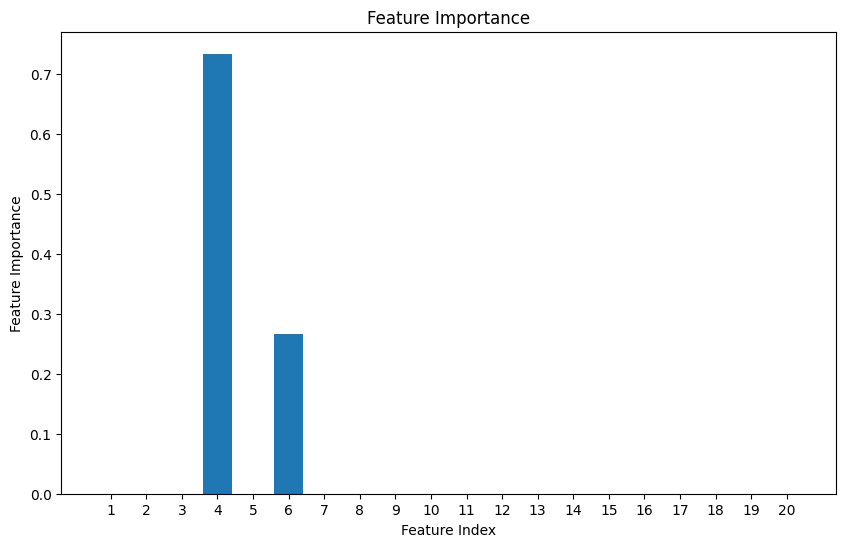

In [123]:
# Step 12: Analyze feature importance
feature_importance = best_model.feature_importances_

# Step 13: Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xticks(range(len(feature_importance)), range(1, len(feature_importance) + 1))
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

Other features do not seem important. There could be an issue with how AdaBoostRegressor treats these features. Let's immediately train the biggest set of 50 best features

## 50 features

In [124]:
# Step 1: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_br50.drop(columns=["etr"]), train_y, test_size=0.2, random_state=42)

# Step 2: Create a weak regressor (e.g., Decision Tree)
base_regressor = DecisionTreeRegressor(max_depth=1)

# Step 3: Create an AdaBoost regressor
adaboost_regressor = AdaBoostRegressor(base_regressor, random_state=42)

# Step 4: Define hyperparameters for tuning
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 300, 500],  # Number of weak regressors
    'learning_rate': [0.01, 0.1, 0.5, 1.0, 5, 10] # Learning rate
}

# Step 5: Create a GridSearchCV object for hyperparameter tuning
grid_search = GridSearchCV(estimator=adaboost_regressor, param_grid=param_grid, cv=5)

# Step 6: Train the model with cross-validation
grid_search.fit(X_train, y_train)

# Step 7: Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Step 8: Get the best model
best_model = grid_search.best_estimator_

# Step 9: Make predictions on the test set using the best model
#y_pred = best_model.predict(X_test)

# Step 10: Evaluate the model - test R^2
score = best_model.score(X_test, y_test) #   grid_search.score(X_test, y_test)
print("Score (test R^2):", score )

Best Hyperparameters: {'learning_rate': 0.01, 'n_estimators': 50}
Score (test R^2): 0.08279640615210915


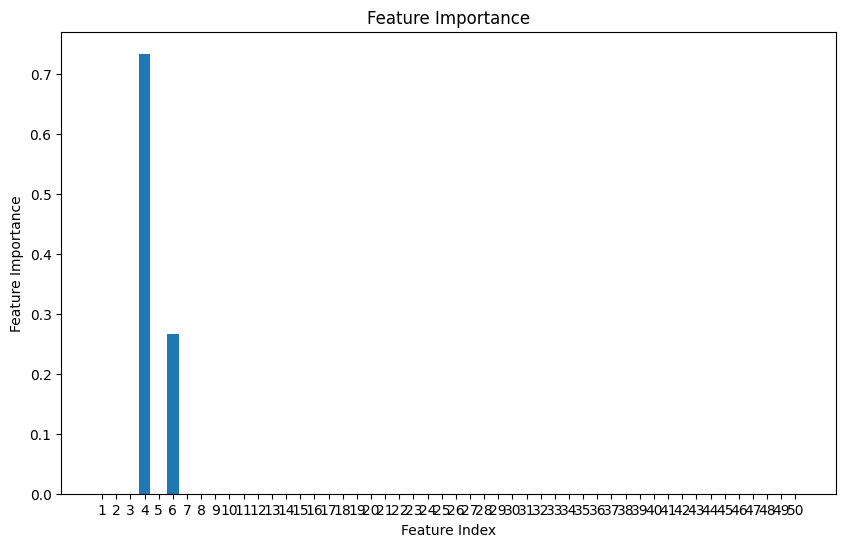

In [125]:
# Step 12: Analyze feature importance
feature_importance = best_model.feature_importances_

# Step 13: Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xticks(range(len(feature_importance)), range(1, len(feature_importance) + 1))
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

This is very odd because it woud suggest that almost no feature is important

# GBM


## 10  features

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_br10.drop(columns=["etr"]), train_y, test_size=0.2, random_state=42)

# 1. Define the model
gbr = GradientBoostingRegressor(random_state=42)

# 2. Create the hyperparameter grid
param_grid = {
    'n_estimators': [ 50, 100, 200],        # number of boosting stages
    'learning_rate': [0.1, 0.05, 0.01],     # shrinkage
    'max_depth': [3, 4, 5],                 # depth of each regression tree
    'min_samples_split': [2, 5, 10],        # The minimum number of samples required to split an internal node:
    'min_samples_leaf': [2, 4, 5],           # The minimum number of samples required to be at a leaf node. 
    #'subsample': [1.0, 0.8, 0.6] ,           # stochastic gradient boosting
    'n_iter_no_change':[25]               # early stopping
}

# 3. Create GridSearchCV
grid_search_GBM = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

# 4. Fit
grid_search_GBM.fit(X_train, y_train)

# 5. Best params
print("Best parameters:", grid_search_GBM.best_params_)

# 6. Best model
best_gbr = grid_search_GBM.best_estimator_

# 7. Predict
y_pred_gbr10 = best_gbr.predict(X_test)

# 8. Evaluate
print("R2 score:", r2_score(y_test, y_pred)) #same as for AdaBoostingRegressor
print("RMSE:", root_mean_squared_error(y_test, y_pred)) 
print("MAE:", mean_absolute_error(y_test, y_pred))

Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'n_iter_no_change': 25}
R2 score: 0.13491383692279146
RMSE: 0.14777755705223386
MAE: 0.07939642288501528


In [133]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_br10.drop(columns=["etr"]), train_y, test_size=0.2, random_state=42)

# 1. Define the model
gbr = GradientBoostingRegressor(random_state=42)

# 2. Create the hyperparameter grid
param_grid = {
    'n_estimators': [ 50, 100, 200],        # number of boosting stages
    'learning_rate': [0.1, 0.05, 0.01],     # shrinkage
    'max_depth': [3, 4, 5],                 # depth of each regression tree
    'min_samples_split': [2, 5, 10],        # The minimum number of samples required to split an internal node:
    'min_samples_leaf': [2, 4, 5],           # The minimum number of samples required to be at a leaf node. 
    'subsample': [1.0, 0.8, 0.6] ,           # stochastic gradient boosting
    'n_iter_no_change':[25]               # early stopping
}

# 3. Create GridSearchCV
grid_search_GBM = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

# 4. Fit
grid_search_GBM.fit(X_train, y_train)

# 5. Best params
print("Best parameters:", grid_search_GBM.best_params_)

# 6. Best model
best_gbr = grid_search_GBM.best_estimator_

# 7. Predict
y_pred = best_gbr.predict(X_test)

# 8. Evaluate
print("R2 score:", r2_score(y_test, y_pred)) #same as for AdaBoostingRegressor
print("RMSE:", root_mean_squared_error(y_test, y_pred)) 
print("MAE:", mean_absolute_error(y_test, y_pred))

Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'n_iter_no_change': 25, 'subsample': 1.0}
R2 score: 0.13491383692279146
RMSE: 0.14777755705223386
MAE: 0.07939642288501528


The addition of stochastic gradient boosting was very taxing computationally but didn't bring any improvements

In [134]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import plotly.express as px

# === Hyperparameter grid (your updated one) ===
n_estimators_values      = [50, 100, 200]
learning_rate_values     = [0.1, 0.05, 0.01]
max_depth_values         = [3, 4, 5]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [2, 4, 5]
subsample_values         = [1.0, 0.8, 0.6]
n_iter_no_change_values  = [25]   # single value, but kept for completeness

results = []

for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
        for max_depth in max_depth_values:
            for min_samples_split in min_samples_split_values:
                for min_samples_leaf in min_samples_leaf_values:
                    for subsample in subsample_values:
                        for n_iter_no_change in n_iter_no_change_values:
                            # Initialize the GradientBoostingRegressor with current hyperparameters
                            gbm = GradientBoostingRegressor(
                                n_estimators=n_estimators,
                                learning_rate=learning_rate,
                                subsample=subsample,
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf,
                                n_iter_no_change=n_iter_no_change,
                                random_state=42
                            )
                            gbm.fit(X_train, y_train)

                            # Predict on the test set
                            y_pred = gbm.predict(X_test)

                            # Calculate MSE
                            mse = mean_squared_error(y_test, y_pred)

                            results.append((
                                n_estimators,
                                learning_rate,
                                max_depth,
                                min_samples_split,
                                min_samples_leaf,
                                subsample,
                                n_iter_no_change,
                                mse
                            ))

# Create DataFrame for parallel coordinates
df_coordinate_plots = pd.DataFrame(
    results,
    columns=[
        'n_estimators',
        'learning_rate',
        'max_depth',
        'min_samples_split',
        'min_samples_leaf',
        'subsample',
        'n_iter_no_change',
        'MSE'
    ]
)

# Parallel coordinates plot
fig = px.parallel_coordinates(
    df_coordinate_plots,
    color="MSE",
    color_continuous_scale=px.colors.colorbrewer.RdBu,
    labels={col: col for col in df_coordinate_plots.columns}
)
fig.update_layout(
    title="Impact of Different Hyperparameters on MSE"
)
fig.show()


In [142]:
# To keep better track of the models
best_gbr10=best_gbr

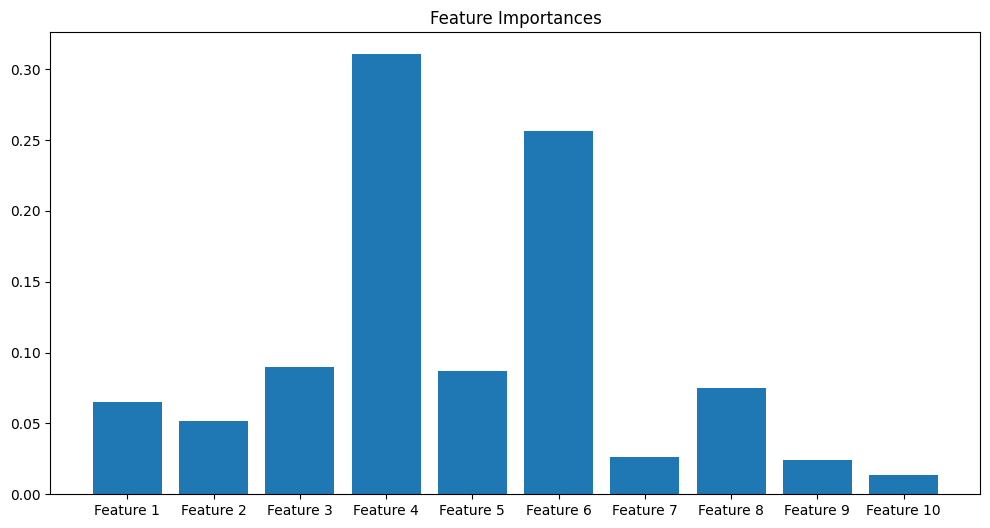

In [150]:
# Step 4: Feature Selection Based on Feature Importance
# Calculate feature importances
feature_importances = best_gbr10.feature_importances_

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances, tick_label=[f'Feature {i+1}' for i in range(len(feature_importances))])
plt.title("Feature Importances")
plt.show()


Feature 4 and 6 remain very important (see AdaBoost). GBM also manages to utilise other features better than AdaBoost as we see the same features as before but now with greater FI scores.

## 20 features

While results could be different in this case, we will forego checking if stochastic gradient boosting is relevant due to computational costs.

In [145]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_br20.drop(columns=["etr"]), train_y, test_size=0.2, random_state=42)

# 1. Define the model
gbr = GradientBoostingRegressor(random_state=42)

# 2. Create the hyperparameter grid
param_grid = {
    'n_estimators': [ 50, 100, 200],        # number of boosting stages
    'learning_rate': [0.1, 0.05, 0.01],     # shrinkage
    'max_depth': [3, 4, 5],                 # depth of each regression tree
    'min_samples_split': [2, 5, 10],        # The minimum number of samples required to split an internal node:
    'min_samples_leaf': [2, 4, 5],           # The minimum number of samples required to be at a leaf node. 
    #'subsample': [1.0, 0.8, 0.6] ,           # stochastic gradient boosting
    'n_iter_no_change':[25]               # early stopping
}

# 3. Create GridSearchCV
grid_search_GBM = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

# 4. Fit
grid_search_GBM.fit(X_train, y_train)

# 5. Best params
print("Best parameters:", grid_search_GBM.best_params_)

# 6. Best model
best_gbr20 = grid_search_GBM.best_estimator_

# 7. Predict
y_pred = best_gbr20.predict(X_test)

# 8. Evaluate
print("R2 score:", r2_score(y_test, y_pred)) #same as for AdaBoostingRegressor
print("RMSE:", root_mean_squared_error(y_test, y_pred)) 
print("MAE:", mean_absolute_error(y_test, y_pred))

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50, 'n_iter_no_change': 25}
R2 score: 0.13415362258816488
RMSE: 0.14784247425466168
MAE: 0.07945838281010138


The RMSE actually went slightly up - we might be overfitting. 

## 30 features

In [146]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_br30.drop(columns=["etr"]), train_y, test_size=0.2, random_state=42)

# 1. Define the model
gbr = GradientBoostingRegressor(random_state=42)

# 2. Create the hyperparameter grid
param_grid = {
    'n_estimators': [ 50, 100, 200],        # number of boosting stages
    'learning_rate': [0.1, 0.05, 0.01],     # shrinkage
    'max_depth': [3, 4, 5],                 # depth of each regression tree
    'min_samples_split': [2, 5, 10],        # The minimum number of samples required to split an internal node:
    'min_samples_leaf': [2, 4, 5],           # The minimum number of samples required to be at a leaf node. 
    #'subsample': [1.0, 0.8, 0.6] ,           # stochastic gradient boosting
    'n_iter_no_change':[25]               # early stopping
}

# 3. Create GridSearchCV
grid_search_GBM = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

# 4. Fit
grid_search_GBM.fit(X_train, y_train)

# 5. Best params
print("Best parameters:", grid_search_GBM.best_params_)

# 6. Best model
best_gbr30 = grid_search_GBM.best_estimator_

# 7. Predict
y_pred = best_gbr30.predict(X_test)

# 8. Evaluate
print("R2 score:", r2_score(y_test, y_pred)) #same as for AdaBoostingRegressor
print("RMSE:", root_mean_squared_error(y_test, y_pred)) 
print("MAE:", mean_absolute_error(y_test, y_pred))

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'n_iter_no_change': 25}
R2 score: 0.13675305776582614
RMSE: 0.14762038185308735
MAE: 0.07891376815353546


RMSE marginally went down. Let's look at FI

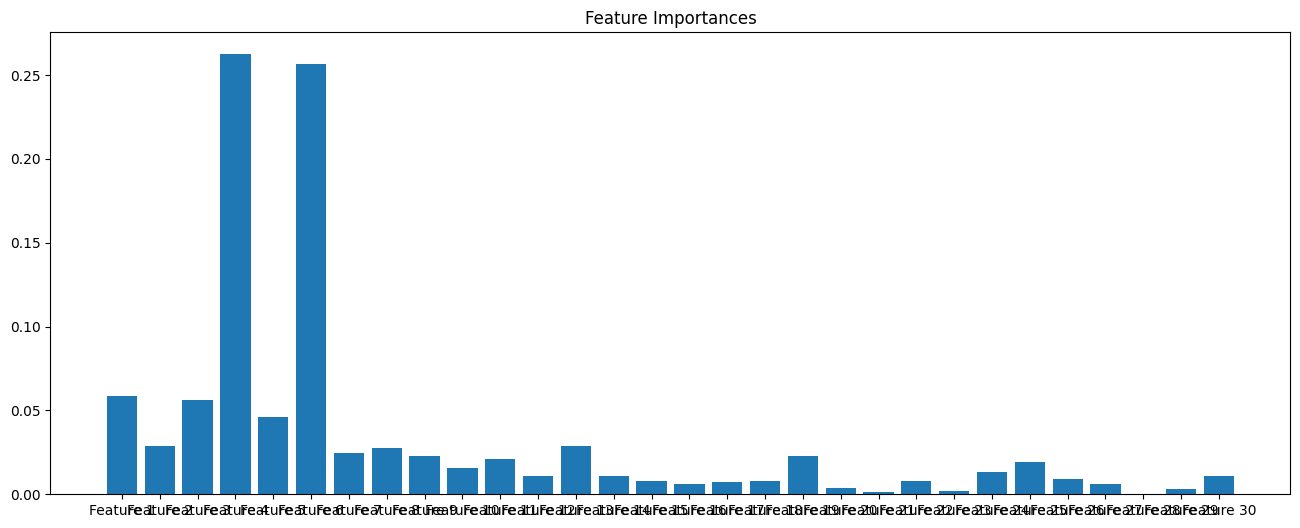

In [151]:
# Step 4: Feature Selection Based on Feature Importance
# Calculate feature importances
feature_importances = best_gbr30.feature_importances_

# Plot feature importances
plt.figure(figsize=(16, 6))
plt.bar(range(len(feature_importances)), feature_importances, tick_label=[f'Feature {i+1}' for i in range(len(feature_importances))])
plt.title("Feature Importances")
plt.show()

As expected, FI values generally go down. Features were chosen in descending order of the Boruta rank score so that we deal with the most "valuable" features first. Let's reestimate the model on a smaller number of features

In [154]:
# Set a threshold for selecting important features (you can adjust this threshold)
threshold = 0.03

# Create a feature selector
feature_selector = SelectFromModel(best_gbr30, threshold=threshold, prefit=True)

# Transform your dataset to select important features
X_train_selected = feature_selector.transform(X_train)
X_test_selected = feature_selector.transform(X_test)

# 1. Define the model
gbr = GradientBoostingRegressor(random_state=42)

# 2. Create the hyperparameter grid
param_grid = {
    'n_estimators': [ 50, 100, 200],        # number of boosting stages
    'learning_rate': [0.1, 0.05, 0.01],     # shrinkage
    'max_depth': [3, 4, 5],                 # depth of each regression tree
    'min_samples_split': [2, 5, 10],        # The minimum number of samples required to split an internal node:
    'min_samples_leaf': [2, 4, 5],           # The minimum number of samples required to be at a leaf node. 
    #'subsample': [1.0, 0.8, 0.6] ,           # stochastic gradient boosting
    'n_iter_no_change':[25]               # early stopping
}

# 3. Create GridSearchCV
grid_search_GBM = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

# 4. Fit
grid_search_GBM.fit(X_train_selected, y_train)

# 5. Best params
print("Best parameters:", grid_search_GBM.best_params_)

# 6. Best model
best_gbr30_FI = grid_search_GBM.best_estimator_

# 7. Predict
y_pred = best_gbr30_FI.predict(X_test_selected)

# 8. Evaluate
print("R2 score:", r2_score(y_test, y_pred)) #same as for AdaBoostingRegressor
print("RMSE:", root_mean_squared_error(y_test, y_pred)) 
print("MAE:", mean_absolute_error(y_test, y_pred))

Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50, 'n_iter_no_change': 25}
R2 score: 0.11993750665180702
RMSE: 0.14905122727529996
MAE: 0.0788163932232422


Surprisingly, RMSE rose. We will stick to the previous model as the best GBM candidate.

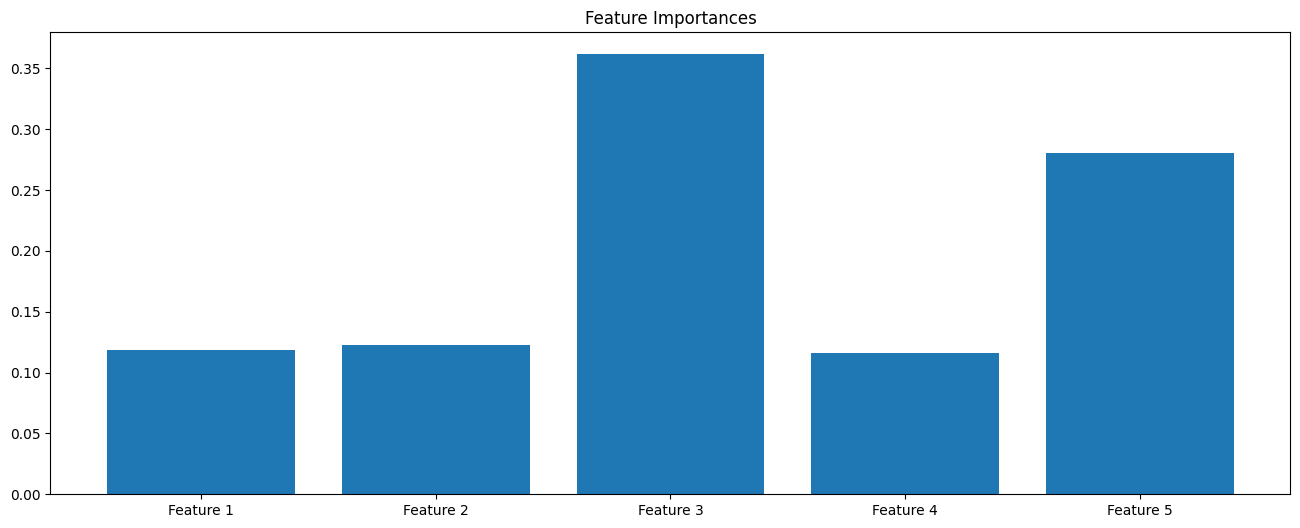

In [155]:
# Step 4: Feature Selection Based on Feature Importance
# Calculate feature importances
feature_importances = best_gbr30_FI.feature_importances_

# Plot feature importances
plt.figure(figsize=(16, 6))
plt.bar(range(len(feature_importances)), feature_importances, tick_label=[f'Feature {i+1}' for i in range(len(feature_importances))])
plt.title("Feature Importances")
plt.show()

Surprisingly, in this case feature 4 isn't the best. In the previous plot we saw that feature 4's value was far greater than that of feature 3, for example.

# GBM Histogram


This improves the speed of a classic GBM by employing the histogram bundling functionality from LightGBM. 

**From the documentation:**
"This estimator is much faster than GradientBoostingRegressor for big datasets (n_samples >= 10 000). This estimator has native support for missing values (NaNs). During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. When predicting, samples with missing values are assigned to the left or right child consequently. If no missing values were encountered for a given feature during training, then samples with missing values are mapped to whichever child has the most samples. See Features in Histogram Gradient Boosting Trees for a usecase example of this feature."

## 10 features

In [166]:
# Split the data into training and testing sets
X_train_hgbr10, X_test_hgbr10, y_train_hgbr10, y_test_hgbr10 = train_test_split(train_br10.drop(columns=["etr"]), train_y, test_size=0.2, random_state=42)

# 1. Define the model
hgbr = HistGradientBoostingRegressor(random_state=42)

# 2. Create the hyperparameter grid
param_grid = {
    'max_iter': [ 50, 100, 200],        # number of boosting stages
    'learning_rate': [0.1, 0.05, 0.02],              # shrinkage
    'max_depth': [3, 4, 5],                 # depth of each regression tree        
    'min_samples_leaf': [2, 5, 10],           # The minimum number of samples required to be at a leaf node. 
    #'subsample': [1.0, 0.8, 0.6] ,           # stochastic gradient boosting
    'n_iter_no_change':[10, 25],                 # early stopping
    'validation_fraction': [0.1, 0.2],            # in conjunction with n_iter_no_change
    'max_bins': [50, 100, 200],              # maximum number of histogram bins
    'l2_regularization': [0, 1e-3, 1e-2]             # punish leaves with small hessians
}

# 3. Create GridSearchCV
grid_search_HGBM = GridSearchCV(
    estimator=hgbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

# 4. Fit
grid_search_HGBM.fit(X_train_hgbr10, y_train_hgbr10)

# 5. Best params
print("Best parameters:", grid_search_HGBM.best_params_)

# 6. Best model
best_hgbr10 = grid_search_HGBM.best_estimator_

# 7. Predict
y_pred_hgbr10 = best_hgbr10.predict(X_test_hgbr10)

# 8. Evaluate
print("R2 score:", r2_score(y_test_hgbr10, y_pred_hgbr10)) #same as for AdaBoostingRegressor
print("RMSE:", root_mean_squared_error(y_test_hgbr10, y_pred_hgbr10)) 
print("MAE:", mean_absolute_error(y_test_hgbr10, y_pred_hgbr10))

Best parameters: {'l2_regularization': 0, 'learning_rate': 0.1, 'max_bins': 100, 'max_depth': 3, 'max_iter': 50, 'min_samples_leaf': 2, 'n_iter_no_change': 10, 'validation_fraction': 0.1}
R2 score: 0.1327782134944635
RMSE: 0.14795985257906882
MAE: 0.07923169985607821


This best configuration of HistGBM has worse RMSE than our best version of GBM. FI isn't built into HistGBM so we have to use a substitute - permutation importance.

**From documentation:** 
Permutation importance for feature evaluation.

The estimator is required to be a fitted estimator. X can be the data set used to train the estimator or a hold-out set. The permutation importance of a feature is calculated as follows. First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. Next, a feature column from the validation set is permuted and the metric is evaluated again. The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.

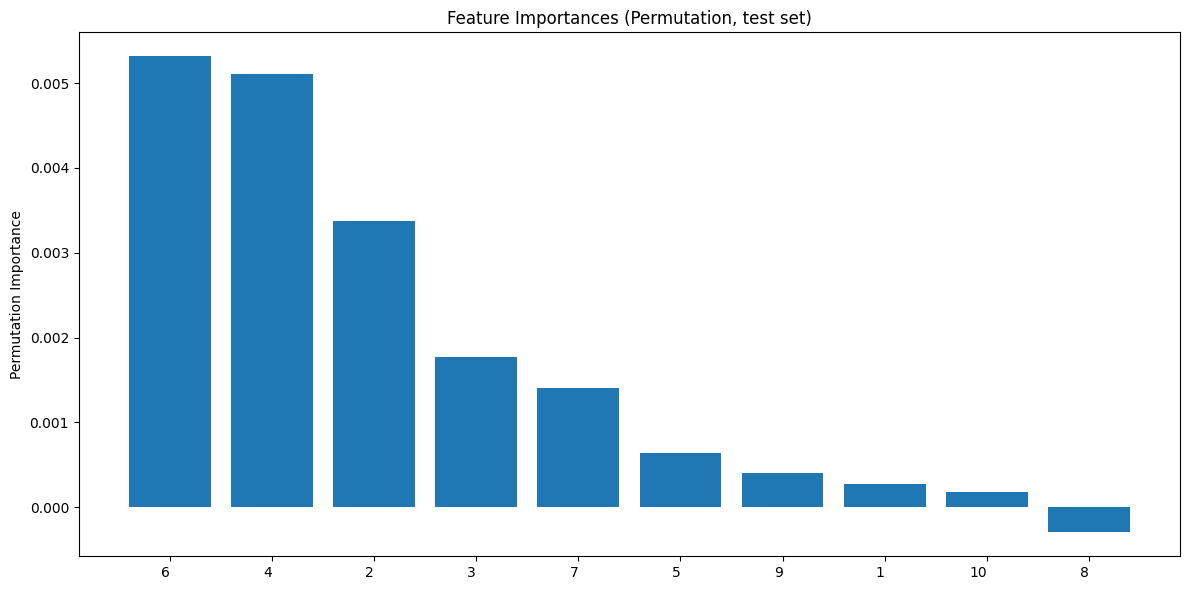

In [ ]:
from sklearn.inspection import permutation_importance

# --- Permutation importance on the test set ---
result = permutation_importance(
    best_hgbr10,
    X_test_hgbr10,
    y_test_hgbr10,
    n_repeats=10,
    random_state=42,
    scoring='neg_root_mean_squared_error'
)

importances_mean = result.importances_mean
importances_std = result.importances_std

# Sort features by importance (descending)
indices = np.argsort(importances_mean)[::-1]

# --- Bar plot like in your screenshot ---
plt.figure(figsize=(12, 6))
plt.bar(
    range(len(indices)),
    importances_mean[indices]
)
plt.xticks(
    range(len(indices)),
    indices+1, # due to the numbering of arrays starting at 0
    rotation=0,
    ha="right"
)
plt.ylabel("Permutation Importance")
plt.title("Feature Importances (Permutation, test set)")
plt.tight_layout()
plt.show()


Feature 4 and 6 are again the favourites in our ranking

## 20 features

In [161]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_br20.drop(columns=["etr"]), train_y, test_size=0.2, random_state=42)

# 1. Define the model
hgbr = HistGradientBoostingRegressor(random_state=42)

# 2. Create the hyperparameter grid
param_grid = {
    'max_iter': [ 50, 100, 200],        # number of boosting stages
    'learning_rate': [0.1, 0.05, 0.02],              # shrinkage
    'max_depth': [3, 4, 5],                 # depth of each regression tree        
    'min_samples_leaf': [2, 5, 10],           # The minimum number of samples required to be at a leaf node. 
    #'subsample': [1.0, 0.8, 0.6] ,           # stochastic gradient boosting
    'n_iter_no_change':[10, 25],                 # early stopping
    'validation_fraction': [0.1, 0.2],            # in conjunction with n_iter_no_change
    'max_bins': [50, 100, 200],              # maximum number of histogram bins
    'l2_regularization': [0, 1e-3, 1e-2]             # punish leaves with small hessians
}

# 3. Create GridSearchCV
grid_search_HGBM = GridSearchCV(
    estimator=hgbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

# 4. Fit
grid_search_HGBM.fit(X_train, y_train)

# 5. Best params
print("Best parameters:", grid_search_HGBM.best_params_)

# 6. Best model
best_hgbr20 = grid_search_HGBM.best_estimator_

# 7. Predict
y_pred_hgbr20 = best_hgbr20.predict(X_test)

# 8. Evaluate
print("R2 score:", r2_score(y_test, y_pred_hgbr20)) #same as for AdaBoostingRegressor
print("RMSE:", root_mean_squared_error(y_test, y_pred_hgbr20)) 
print("MAE:", mean_absolute_error(y_test, y_pred_hgbr20))

Best parameters: {'l2_regularization': 0.01, 'learning_rate': 0.02, 'max_bins': 50, 'max_depth': 3, 'max_iter': 200, 'min_samples_leaf': 2, 'n_iter_no_change': 10, 'validation_fraction': 0.1}
R2 score: 0.13096387991954228
RMSE: 0.14811454672558336
MAE: 0.07865564293893297


Our RMSE drastically increased - we are probably overfitting at this point

# XGBoost


# LightGBM

# CatBoost

# XGBoostLSS